In [1]:
import tensorflow
import os

os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
dde.config.set_default_float("float64")

import numpy as np
from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt


2025-09-07 15:27:06.629568: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 15:27:06.670561: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 15:27:08.052513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorc

Set the default float type to float64


W0000 00:00:1757269629.758809   74027 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t0, tf = 0, 50
beta = 0.9
gamma = 0.2 
S0, I0, R0 = 0.99, 0.01, 0.0

In [3]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    
    S, I, R = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    
    return [
        dS_dt - (-beta * S * I),
        dI_dt - (beta * S * I - gamma * I),
        dR_dt - (gamma * I)   
    ]

is_on_initial = lambda _, on_initial: on_initial

ic_S = IC(timeinterval, lambda _: S0, is_on_initial, component=0)
ic_I = IC(timeinterval, lambda _: I0, is_on_initial, component=1)
ic_R = IC(timeinterval, lambda _: R0, is_on_initial, component=2)

conditions = [
    ic_S, ic_I, ic_R,
] 

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32
)

n_hidden_layers = 8
hidden_layer_size = 64
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
# activation = "tanh"
# activation = "gelu"
# activation = "sin"
activation = "relu"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.001
#loss_weights = [100] * 6 + [100] * 3
#loss_weights = [1] * 6 + [100] * 3
#loss_weights = [1] * 9
loss_weights = [1] * (len(conditions) + 3)

net = FNN(
    topology, 
    activation, 
    initializer
)

# net = PFNN(
#     topology, 
#     activation, 
#     initializer
# )

model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.045551 s



In [4]:
losshistory, train_state = model.train(
    iterations=120000, 
    display_every=500
)

model.compile(
    "L-BFGS", 
    lr,
    loss_weights=loss_weights
)

dde.optimizers.set_LBFGS_options(maxiter=30000)

losshistory, train_state = model.train(
    iterations=20000, 
    display_every=500
)

Training model...

Cause: could not parse the source code of <function <lambda> at 0x7f4964b7c720>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f4964b7c720>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could 

2025-09-07 15:27:11.433947: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435145: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435173: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435285: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435309: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435421: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435447: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435556: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435579: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435690: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.435712: W tensorflow/core/util/util.cc:163] Not handling typ

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.51e-04, 1.27e-02, 2.78e-03, 9.80e-01, 1.00e-04, 0.00e+00]    [2.40e-04, 1.26e-02, 2.67e-03, 9.80e-01, 1.00e-04, 0.00e+00]    []  


2025-09-07 15:27:11.649781: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.650943: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.650969: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651089: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651113: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651230: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651253: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651371: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651394: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651510: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:27:11.651534: W tensorflow/core/util/util.cc:163] Not handling typ

500       [6.95e-06, 7.10e-06, 2.22e-06, 4.45e-09, 1.43e-07, 3.65e-11]    [2.64e-06, 2.04e-06, 8.52e-07, 4.45e-09, 1.43e-07, 3.65e-11]    []  
1000      [1.41e-05, 8.70e-06, 1.68e-06, 7.56e-09, 1.42e-07, 3.49e-09]    [1.62e-05, 4.61e-06, 7.94e-07, 7.56e-09, 1.42e-07, 3.49e-09]    []  
1500      [9.35e-06, 1.06e-05, 1.83e-06, 4.32e-09, 1.71e-08, 6.22e-09]    [9.62e-06, 7.25e-06, 1.63e-06, 4.32e-09, 1.71e-08, 6.22e-09]    []  
2000      [2.26e-05, 1.27e-05, 2.76e-06, 8.23e-08, 8.96e-07, 8.53e-10]    [2.22e-05, 5.83e-06, 2.40e-06, 8.23e-08, 8.96e-07, 8.53e-10]    []  
2500      [4.78e-06, 8.79e-06, 7.01e-07, 6.61e-10, 3.98e-08, 1.12e-10]    [1.55e-06, 2.11e-06, 4.53e-07, 6.61e-10, 3.98e-08, 1.12e-10]    []  
3000      [1.71e-06, 4.41e-06, 8.25e-07, 2.95e-10, 1.02e-07, 1.42e-10]    [2.03e-06, 1.81e-06, 3.70e-07, 2.95e-10, 1.02e-07, 1.42e-10]    []  
3500      [1.26e-05, 7.41e-06, 1.82e-06, 1.52e-07, 5.94e-08, 2.13e-09]    [5.03e-06, 2.09e-06, 1.83e-06, 1.52e-07, 5.94e-08, 2.13e-09]    []  

2025-09-07 15:31:39.929439: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930598: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930624: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930733: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930756: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930867: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.930890: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.931001: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.931029: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.931169: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-09-07 15:31:39.931193: W tensorflow/core/util/util.cc:163] Not handling typ

120005    [4.47e-07, 3.86e-06, 2.13e-08, 4.95e-11, 2.05e-07, 1.72e-14]    [1.34e-07, 2.18e-06, 8.21e-09, 4.95e-11, 2.05e-07, 1.72e-14]    []  

Best model at step 38500:
  train loss: 3.87e-06
  test loss: 1.82e-06
  test metric: []

'train' took 2.165905 s



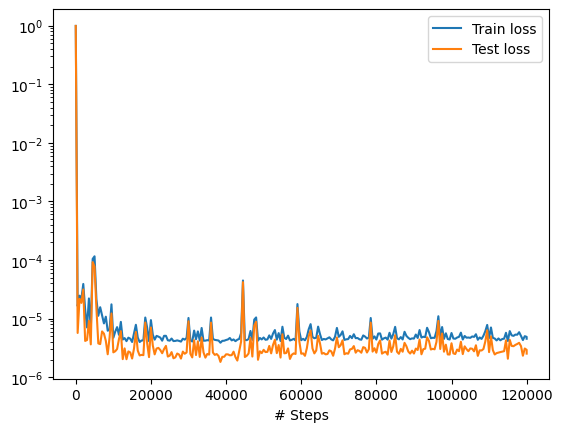

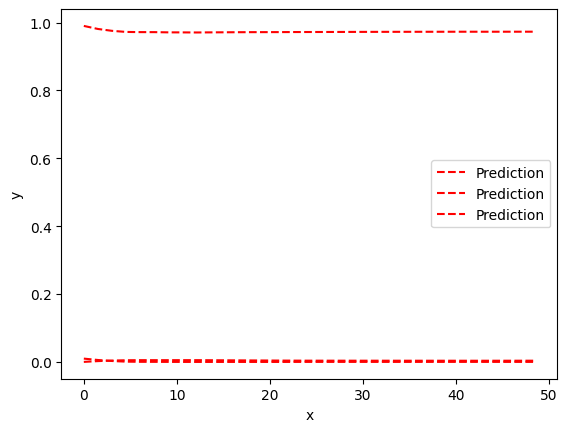

In [5]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=False, 
    isplot=True
)

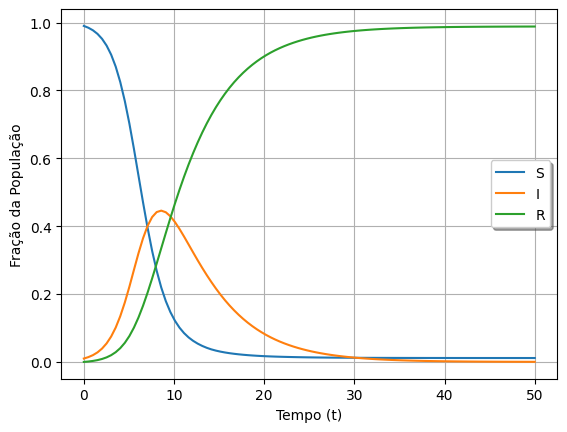

In [6]:
def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta * S * I,
        beta * S * I - gamma * I,
        gamma * I
    ]

sir_sol = solve_ivp(
sir_system,
[t0, tf],
[S0, I0, R0],
args=[gamma],
dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.show()